# VQE アルゴリズム
## 概要
今回は量子化学のアルゴリズム、VQE(Variational Quantum Eigensolver : 変分量子固有値ソルバー)アルゴリズムを紹介する。このアルゴリズムは物質(今回は水素化ヘリウムイオン)の基底エネルギーの値を求めるのに用いられる。

## 背景

化合物の基底エネルギーとは、化合物の状態を行列にした時にその固有値のうち最小のものを指す。行列力学(行列を用いた量子力学の形式)では系全体のエネルギーの演算子はハミルトニアン$\hat{H}$で表され、$$\hat{H}|\psi\rangle = E|\psi\rangle$$で表される。ちなみに、量子系のハミルトニアンは離散値(⇄連続値)で、Eはハミルトニアン行列の固有値である。　

そして、Eの期待値は$E = \sum_{i=1}^ \langle|\psi\hat{H}|\psi\rangle$で求められる。ちなみに、Eの期待値は理論上の基底エネルギー以上であることが知られているので、Eの期待値の最小値が求めたい基底エネルギーである。

## 化学的説明

各原子は複数のエネルギー状態を取るが、そのうち1番安定している状態(エネルギーが少ない状態)を基底状態、不安定な状態(基底状態よりはエネルギーが多い状態)を励起状態という。また、基底エネルギーは物質によって固有なので、基底エネルギーを求めることがその物質の性質を知るのに非常に重要であるが、古典コンピュータでこれを求めようとすると電子数が多ければ多くなるほどパラメータが指数関数的に多くなるため、大きい分子の計算は困難だった。

## アルゴリズム的説明

VQE以前に基底状態を求めるアルゴリズムは提案されており、そのうち１つが位相推定アルゴリズムである。しかし、これは計算を全て量子計算で行うので、NISQ(今開発されている、エラーの影響が大きい中規模量子コンピュータ)では理論値との誤差が大きくなってしまう。そこで考案されたのが、量子状態を計算するのは量子計算で、これを最小化するのは古典計算で分担するハイブリッド量子計算である。

![screen shot 2019-03-01 at 9 45 41 pm](https://user-images.githubusercontent.com/45162150/53639030-71355a80-3c6b-11e9-967f-006063e2af12.png)

(引用元:Peruzzo, A. et al. A variational eigenvalue solver on a photonic quantum processor. Nat. Commun. 5:4213 doi: 10.1038/ncomms5213 (2014)[1])

このアルゴリズムは次の2段階に分かれている。 

1.量子部分でランダムな量子状態$|\psi(\theta)\rangle$を生成する。

2.量子部分で$H$を計算する。  

3.古典部分で$\langle\psi(\theta)|H|\psi(\theta)\rangle$が最小になるような$\theta$を計算する。 

$\langle\psi(\theta)|H|\psi(\theta)\rangle$が最小の値をとるまで1-2を繰り返すのが本アルゴリズムである。  

以下では具体的なnumpyでの実装例で何をやっているか説明していく。 

まずは量子ゲートを用意する。

In [23]:
import numpy as np
#パウリ演算子を準備する。
pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
pHad = (pX+pZ)/np.sqrt(2)
pP0 = (pI+pZ)/2
pP1 = (pI-pZ)/2

In [4]:
#パウリ演算子を1量子ゲートに変換する。
def define_OneQubitGate(nqubits):    
    global X,Y,Z,H,P0,P1,Ide
    X=[1]*(nqubits)
    Y=[1]*(nqubits)
    Z=[1]*(nqubits)
    H=[1]*(nqubits)
    P0=[1]*(nqubits)
    P1=[1]*(nqubits)

    for i in range(nqubits):
        for j in range(nqubits):
            if(i != j):
                X[i] = np.kron(pI,X[i])
                Y[i] = np.kron(pI,Y[i])
                Z[i] = np.kron(pI,Z[i])
                H[i] = np.kron(pI,H[i])
                P0[i] = np.kron(pI,P0[i])
                P1[i] = np.kron(pI,P1[i])
            else:
                X[i] = np.kron(pX,X[i])
                Y[i] = np.kron(pY,Y[i])
                Z[i] = np.kron(pZ,Z[i])
                H[i] = np.kron(pHad,H[i])
                P0[i] = np.kron(pP0,P0[i])
                P1[i] = np.kron(pP1,P1[i])
    Ide = np.eye(2**nqubits)

In [5]:
#2量子ゲートを準備する。
def define_TwoQubitGate(nqubits):
    global CZ,CX
    CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
    CX = [[0 for i in range(nqubits)] for j in range(nqubits)]

    for i in range(nqubits):
        for j in range(nqubits):
            CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
            CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))

In [6]:
#変分量子ゲート(X,Y,Zに関する回転の角度を指定できるゲート)を準備する。
from scipy.linalg import expm
def RX(target,angle):
    return expm(-0.5*angle*1.j*X[target])
def RY(target,angle):
    return expm(-0.5*angle*1.j*Y[target])
def RZ(target,angle):
    return expm(-0.5*angle*1.j*Z[target])

In [7]:
#初期状態|0000・・・0>を準備する。
def StateZeros(nqubits):
    State = np.zeros(2**nqubits)
    State[0]=1
    return State

今回はH-He+(水素化ヘリウムイオン)の基底エネルギーを求める。今回使用する量子ビットは2個である。

In [8]:
#2個用の量子ゲートを定義する。
define_OneQubitGate(2)
define_TwoQubitGate(2)

今回の参考論文( https://www.nature.com/articles/ncomms5213 )のSupplimentary Information( https://media.nature.com/original/nature-assets/ncomms/2014/140723/ncomms5213/extref/ncomms5213-s1.pdf )
より、エネルギーの算出過程の途中から理論値を求められるか検証する。

In [9]:
M = (-3.8505 * Ide  - 0.2288 * X[1] - 1.0466 * Z[1] - 0.2288 * X[0] +  0.2613 * np.dot(X[0],X[1]) + \
     0.2288 *np.dot(X[0],Z[1]) - 1.0466*Z[0] + 0.2288* np.dot(Z[0],X[1]) +  0.2356 * np.dot(Z[0],Z[1]) )/2

H-He+の最初のエネルギーの行列はこれである。

In [10]:
print(M)

[[-2.85405+0.j  0.     +0.j  0.     +0.j  0.13065+0.j]
 [ 0.     +0.j -2.04305+0.j  0.13065+0.j -0.2288 +0.j]
 [ 0.     +0.j  0.13065+0.j -2.04305+0.j -0.2288 +0.j]
 [ 0.13065+0.j -0.2288 +0.j -0.2288 +0.j -0.76085+0.j]]


次に、2量子ビットの変分量子回路を参考論文をもとに実装した。

In [11]:
def TwoQubitPQC(phi):
    state = StateZeros(2)
    state = np.dot(RX(0,phi[0]),state)
    state = np.dot(RZ(0,phi[1]),state)
    state = np.dot(RX(1,phi[2]),state)
    state = np.dot(RZ(1,phi[3]),state)
    state = np.dot(CX[1][0],state)
    state = np.dot(RZ(1,phi[4]),state)
    state = np.dot(RX(1,phi[5]),state)
    return state

変分量子回路を通った後の期待値を算出する関数を定義する。

In [12]:
def ExpectVal(Operator,State):
    BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
    tmp = np.dot(BraState,np.dot(Operator,State)) #行列を列ベクトルと行ベクトルではさむ
    return np.real(tmp) #要素の実部を取り出す

コスト関数$\langle\psi|M|\psi\rangle$の値を並べていく。

In [13]:
cost_val = [] #後々のためにコスト関数の値を格納するリストを用意しておく

def cost_func_HHe(phi):
    global cost_val
    tmp = ExpectVal(M,TwoQubitPQC(phi))
    cost_val.append(tmp)
    return tmp

6回算出する。

In [14]:
cost_func_HHe([np.random.rand() for i in range(6)])

-2.796559457519281

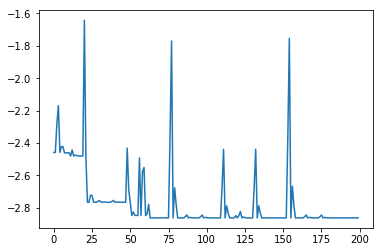

-2.8623984250625636


In [22]:
import scipy.optimize
import matplotlib.pyplot as plt

cost_val=[] # コスト関数の履歴
opt = {"maxiter": 100} #100回繰り返す
#Powell法という最適化法で　<ψ(Θ)|H|ψ(Θ)>を最小化する。
res = scipy.optimize.minimize(cost_func_HHe,[np.random.rand() for i in range(6)],options=opt,method='Powell')
plt.plot(cost_val)
plt.show()
print(res.fun)

行列の固有値を求める「対角化」という方法を使って算出した値が正しいか検証してみる。

In [16]:
import scipy.linalg
l, P = scipy.linalg.eig( M )
v = np.transpose(P)
print(l) # 固有値
#print(v) # 固有ベクトル

[-2.86262076+0.j -0.66884541+0.j -1.99583383+0.j -2.1737    +0.j]


Powell法で算出した固有値と一致はしていないものの、小数第3位まで同じであるので、殆ど正しいと言っていいだろう。　

次にノイズが存在するケースでも検証してみよう。

In [17]:
def cost_func_HHe_noise(phi):
    global cost_val
    tmp = ExpectVal(M,TwoQubitPQC(phi))+np.random.normal(0,0.01)
    cost_val.append(tmp)
    return tmp

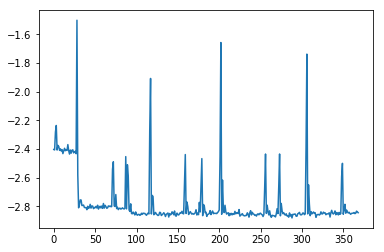

-2.856658530959696


In [21]:
cost_val=[] # コスト関数の履歴
opt = {"maxiter": 100}
res = scipy.optimize.minimize(cost_func_HHe_noise,[np.random.rand() for i in range(6)],options=opt,method='Powell')
plt.plot(cost_val)
plt.show()
print(res.fun)

ノイズが入っているものの、Powell法や対角化の算出値とかなり近い値が得られた。

参考文献 
[1] Peruzzo, A. et al. A variational eigenvalue solver on a photonic quantum processor. Nat. Commun. 5:4213 doi: 10.1038/ncomms5213 (2014) 